In [1]:

import numpy as np
np.random.seed(42)
import sklearn
import os
#import helper
import keras
import pickle
import math
from keras.layers.advanced_activations import LeakyReLU 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline
import pandas as pd

from tqdm import tqdm

from keras.regularizers import l2

import random
import csv
from tensorflow.contrib.layers import flatten
from skimage import transform as transf
#from prettytable import PrettyTable
%matplotlib inline

SEED = 22

Using TensorFlow backend.


In [2]:
# Load pickled data

def load_split_input_data() :

    # TODO: fill this in based on where you saved the training and testing data
    training_file = './data/train.p'
    testing_file = './data/test.p'
    validation_file = './data/valid.p'


    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']
    X_val, y_val = valid['features'], valid['labels']

    print(len(X_train))
    print(len(X_test))
    print(len(X_val))
    print(len(y_val))

    # STOP: Do not change the tests below. Your implementation should pass these tests. 
    assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
    
    return X_train, y_train, X_test, y_test, X_val, y_val


    





In [3]:
#greyscale
# Convert to grayscale

def convert_to_grayscale(X_train,X_test, X_val):

    X_train_rgb = X_train
    X_val_rgb = X_val
    X_train_gry = np.sum(X_train/3, 
                     axis=3, keepdims=True)

    X_test_rgb = X_test
    X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)
    X_val_gry = np.sum(X_val/3, axis=3, keepdims=True)
    
    print('RGB shape:', X_train_rgb.shape)
    print('Grayscale shape:', X_train_gry.shape)
    X_train = X_train_gry
    X_test = X_test_gry
    X_val = X_val_gry
    
    assert(X_train.shape[1:] == (32,32,1)), "The dimensions of the images are not 32 x 32 x 1."
    return X_train,X_test, X_val

In [4]:
def hist_equalize(dataset):
    hist_ds = []
    for img in  dataset:
        img_eq = exposure.equalize_hist(img)
        hist_ds.append(img_eq)
    return np.asarray(hist_ds) 
    

In [5]:
def hist_equalize_set(X_train,  X_test,  X_val):

    #X_train, X_test , X_val = convert_to_grayscale(X_train, X_test, X_val)
    
    #hist equalize
    
    X_train = hist_equalize(X_train)
    X_test = hist_equalize(X_test)
    X_val = hist_equalize(X_val)
    
    
    print("X_train: ", len(X_train))
    print("X_val: ", len(X_val))
    return X_train,  X_test,  X_val


In [6]:
def noralize(X_train, X_test, X_val)    :
    X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
    X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
    X_val = (X_val - X_val.mean())/(np.max(X_val)-np.min(X_val))
    return X_train, X_test, X_val

In [7]:
import matplotlib
matplotlib.rcParams['font.size'] = 8

def adaptive_equalize(data):
    #print(data[0].shape)
    #print(data[0].squeeze().shape)
    print("Applying the Adaptive Equalization Tranformation")
    ae = []
    for i in tqdm(range(len(data))):
        #print(i)
        
        img = exposure.equalize_adapthist(data[i].squeeze(), clip_limit=0.03)
        #print(img.shape)
        #print("...")
        #print(type(img[0][0]))
        img = np.expand_dims(img, axis=2)
        #print(img.shape)
        ae.append(np.asarray(img))
    #print(len(ae))
    return np.asarray(ae)

def adaptive_equalize_set(train,test,val):
    train = adaptive_equalize(train)
    test = adaptive_equalize(test)
    val = adaptive_equalize(val)
    return train,test,val

  


def contrast_stretch_set(train,test,val):
    train = contrast_stretch(train)
    test = contrast_stretch(test)
    val = contrast_stretch(val)
    return train,test,val

  
def contrast_stretch(data):
    #print(data.shape)
    print("Applying the  Contrast-Stretch Transformation")
    cs = []
    for i in tqdm(range(len(data))):
        #print(i)
        p2, p98 = np.percentile(data[i].squeeze(), (2,98))

        img = exposure.rescale_intensity(data[i].squeeze(), in_range=(p2, p98))
        img = np.expand_dims(img, axis=2)
        #print(img.shape)
        cs.append(np.asarray(img))
    #print(len(d))
    return cs

#print(X_aug.squeeze().shape)
#a = contrast_stretch(np.asarray([img_d,img_b]))
#helper.plot_images(-1,a,2,"")


In [8]:
X_train, y_train, X_test, y_test,X_val,y_val = load_split_input_data()
X_train_g, X_test_g,X_val_g = convert_to_grayscale(X_train, X_test,X_val)

34799
12630
4410
4410
RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


In [23]:
n_classes=43
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
   # horizontal_flip=True,
)
import os
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle





def data_augment(X,y):

    
    img_shape = [X.shape[1], X.shape[2], X.shape[3]]
    img_shape.insert(0,0)
    
    data_shape = np.asarray(img_shape)
    total_image_per_class = 1000
    
    X_augmented =np.empty(data_shape)
    y_augmented =np.empty(0,dtype='uint8')
    


    print('Augmenting  Data...')
    for i in tqdm(range(n_classes)):
    #for i in tqdm(range(3)):
            #print(i)
            index = [y==i]
            images_for_i_class = X[y==i]
            y_i_class = y[y==i]
            X_augmented_i = np.empty(data_shape)
            #print(X_augmented_i.shape)
            y_augmented_i = np.empty(0,dtype='uint8')
            for X_b,y_b in datagen.flow(images_for_i_class, y_i_class, batch_size=len(y_i_class), seed=9345+i*37):            
                X_augmented_i = np.append(X_augmented_i, X_b, axis=0)
                y_augmented_i = np.append(y_augmented_i, y_b, axis=0)

                if len(X_augmented_i) >= total_image_per_class:
                    break
            X_augmented_i, y_augmented_i = shuffle(X_augmented_i, y_augmented_i, random_state=9345)
            X_augmented = np.append(X_augmented, X_augmented_i[:200], axis=0)
            y_augmented = np.append(y_augmented, y_augmented_i[:200], axis=0)     
    print("shufle")
    X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=9345)
    print("X_augmented shape: "+str(X_augmented.shape))
    print("y_augmented shape: "+str(y_augmented.shape))
    return X_augmented, y_augmented
    
    # Storing for checkpoint2
    #X_augmented = X_augmented.astype('float32')

    
    



In [ ]:

X_train_h, X_test_h, X_val_h = hist_equalize_set(X_train_g, X_test_g, X_val_g)
X_train_n, X_test_n,X_val_n = noralize(X_train_g, X_test_g,X_val_g)
X_train_hae ,X_test_hae, X_val_hae = adaptive_equalize_set(X_train_h, X_test_h, X_val_h)
X_train_ae, X_test_ae, X_val_ae = adaptive_equalize_set(X_train_n,X_test_n,X_val_n)
X_train_hcs,X_test_hcs,X_val_hcs = contrast_stretch_set(X_train_h,X_test_h,X_val_h)
X_train_cs,X_test_cs,X_val_cs = contrast_stretch_set(X_train_n,X_test_n,X_val_n)
X_aug_n,y_aug_n = data_augment(X_train_n, y_train)
X_aug_h,y_aug_h = data_augment(X_train_h, y_train)
X_aug_hae,y_aug_hae = data_augment(X_train_hae, y_train)
X_aug_ae,y_aug_ae = data_augment(X_train_ae, y_train)
X_aug_cs,y_aug_cs = data_augment(np.asarray(X_train_cs), y_train)
X_aug_hcs,y_aug_hcs = data_augment(np.asarray(X_train_hcs), y_train)


In [11]:
X_all = X_train_h
y_all = y_train
X_all = np.append(X_all,np.asarray(X_train_hcs),axis=0)
y_all = np.append(y_all,y_train,axis=0)

X_all = np.append(X_all,X_train_hae,axis=0)
y_all= np.append(y_all,y_train,axis=0)
print(X_all.shape)
print(y_all.shape)

(104397, 32, 32, 1)
(104397,)


In [39]:


X_aug_all, y_aug_all = data_augment(X_all,y_all)
print(X_aug_all.shape)
print(y_aug_all.shape)


(104397, 32, 32, 1)
(104397,)


In [9]:
#Save to Disk
def save_to_disk(X_train,y_train,X_test,y_test,X_val,y_val,X_aug,y_aug,flag_color,preop):
# Save the data for easy access
    
    
    assert(len(X_train) == len(y_train)), "The number of images is not equal to the number of labels."
    assert(len(X_test) == len(y_test)), "The number of images is not equal to the number of labels."
    assert(len(X_val) == len(y_val)), "The number of images is not equal to the number of labels."

    if flag_color == True:
        label="_"+preop+"_color"
    else:
        label = "_"+preop+"_gray"
    
    print(label)
    
    
    pickle_file = 'preprocessed'+label+".p"
    print(pickle_file)
    if not os.path.isfile(pickle_file):
        print('Saving data to'+pickle_file+' file...')
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'y_train': y_train,
                        'X_train': X_train,
                        'X_val': X_val,
                        'y_val': y_val,
                        'X_test': X_test,
                        'y_test': y_test,
                        'X_aug': X_aug,
                        'y_aug':y_aug

                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                raise
        
        print('Data cached in pickle file.')
def save_aug_all_to_disk(X_aug_all,y_aug_all):
    assert(len(X_aug_all) == len(y_aug_all)), "The number of images is not equal to the number of labels."

    
    label="preprocessed_aug_all_gray"
    
    
    print(label)
    
    
    pickle_file = label+".p"
    print(pickle_file)
    if not os.path.isfile(pickle_file):
        print('Saving data to'+pickle_file+' file...')
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'y_aug_all': y_aug_all,
                        'X_aug_all': X_aug_all,
                        

                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                raise
        
        print('Data cached in pickle file.')


def load_preprocessed_data(pickle_file):

    print(pickle_file)
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['X_train']
   
        y_train = pickle_data['y_train']
        X_val = pickle_data['X_val']
        y_val = pickle_data['y_val']
        X_test = pickle_data['X_test']
        y_test = pickle_data['y_test']
        X_aug = pickle_data['X_aug']
        y_aug = pickle_data['y_aug']

        del pickle_data  # Free up memory

        print("X_train: ", len(X_train))
        print("y_train: ", len(y_train))
        print("X_val: ", len(X_val))
        print("y_val: ", len(y_val))
        print("X_test: ", len(X_test))
        print("y_test: ", len(y_test))
        print("X_aug: ", len(X_aug))
        print("y_aug: ", len(y_aug))
        # STOP: Do not change the tests below. Your implementation should pass these tests. 
        assert(len(X_train) == len(y_train)), "The number of images is not equal to the number of labels."
        assert(len(X_test) == len(y_test)), "The number of images is not equal to the number of labels."
        assert(len(X_val) == len(y_val)), "The number of images is not equal to the number of labels."

        print('Data and modules loaded.')
        
    return X_train,y_train,X_test,y_test,X_val,y_val,X_aug,y_aug

#save_to_disk(X_train[:4],y_train[:4],X_test[:4],y_test[:4],X_val[:4],y_val[:4],False,"original")
def load_preprocessed_aug(pickle_file):

    print(pickle_file)
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_aug_all = pickle_data['X_aug_all']
   
        y_aug_all = pickle_data['y_aug_all']
        

        del pickle_data  # Free up memory

        print("X_aug_all: ", len(X_aug_all))
        print("y_aug_all: ", len(y_aug_all))
       
        # STOP: Do not change the tests below. Your implementation should pass these tests. 
        assert(len(X_aug_all) == len(y_aug_all)), "The number of images is not equal to the number of labels."
        print('Data and modules loaded.')
        
    return X_aug_all,y_aug_all

#save_to_disk(X_train[:4],y_train[:4],X_test[:4],y_test[:4],X_val[:4],y_val[:4],False,"original")


In [ ]:
save_to_disk(X_train_n,y_train,X_test_n,y_test,X_val_n,y_val,X_aug_n,y_aug_n,False,"norm")
save_to_disk(X_train_h,y_train,X_test_h,y_test,X_val_h,y_val,X_aug_h,y_aug_h,False,"hist")
save_to_disk(X_train_hae,y_train,X_test_hae,y_test,X_val_hae,y_val,X_aug_hae,y_aug_hae,False,"hae")
save_to_disk(X_train_ae,y_train,X_test_ae,y_test,X_val_ae,y_val,X_aug_ae,y_aug_ae,False,"ae")
save_to_disk(X_train_hcs,y_train,X_test_hcs,y_test,X_val_hcs,y_val,X_aug_hcs,y_aug_hcs,False,"hcs")
save_to_disk(X_train_cs,y_train,X_test_cs,y_test,X_val_cs,y_val,X_aug_cs,y_aug_cs,False,"cs")
save_aug_all_to_disk(X_aug_all,y_aug_all)

In [10]:
X_train_n,y_train,X_test_n,y_test,X_val_n,y_val,X_aug_n,y_aug_n = load_preprocessed_data("./preprocessed/preprocessed_norm_gray.p")
X_train_h,y_train,X_test_h,y_test,X_val_h,y_val,X_aug_h,y_aug_h = load_preprocessed_data("./preprocessed/preprocessed_hist_gray.p")
X_train_hae,y_train,X_test_hae,y_test,X_val_hae,y_val,X_aug_hae,y_aug_hae = load_preprocessed_data("./preprocessed/preprocessed_hae_gray.p")
X_train_ae,y_train,X_test_ae,y_test,X_val_ae,y_val,X_aug_ae,y_aug_ae = load_preprocessed_data("./preprocessed/preprocessed_ae_gray.p")
X_train_hcs,y_train,X_test_hcs,y_test,X_val_hcs,y_val,X_aug_hcs,y_aug_hcs = load_preprocessed_data("./preprocessed/preprocessed_hcs_gray.p")
X_train_cs,y_train,X_test_cs,y_test,X_val_cs,y_val,X_aug_cs,y_aug_cs = load_preprocessed_data("./preprocessed/preprocessed_cs_gray.p")
X_aug_all, y_aug_all = load_preprocessed_aug("./preprocessed/preprocessed_aug_all_gray.p")

./preprocessed/preprocessed_norm_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_hist_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_hae_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_ae_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_hcs_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_cs_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  1263

In [12]:
#augment
#X_aug_n=y_aug_n=X_aug_h=y_aug_h=X_aug_hae=y_aug_ae=X_aug_cs=y_aug_hcs=[]
X_aug_n = np.append(X_aug_n,X_train_n,axis=0)
y_aug_n = np.append(y_aug_n,y_train,axis=0)

X_aug_h = np.append(X_aug_h,X_train_h,axis=0)
y_aug_h = np.append(y_aug_h,y_train,axis=0)

X_aug_hae = np.append(X_aug_hae,X_train_hae,axis=0)
y_aug_hae = np.append(y_aug_hae,y_train,axis=0)

X_aug_ae = np.append(X_aug_ae,X_train_ae,axis=0)
y_aug_ae = np.append(y_aug_ae,y_train,axis=0)

X_aug_cs = np.append(X_aug_cs,X_train_cs,axis=0)
y_aug_cs = np.append(y_aug_cs,y_train,axis=0)

X_aug_hcs = np.append(X_aug_hcs,X_train_hcs,axis=0)
y_aug_hcs = np.append(y_aug_hcs,y_train,axis=0)


X_aug_all = np.append(X_aug_all,X_all,axis=0)
y_aug_all = np.append(y_aug_all,y_all,axis=0)

assert(len(X_aug_n) == len(y_aug_n)), "The number of images is not equal to the number of labels."
assert(len(X_aug_h) == len(y_aug_h)), "The number of images is not equal to the number of labels."
assert(len(X_aug_hae) == len(y_aug_hae)), "The number of images is not equal to the number of labels."
assert(len(X_aug_ae) == len(y_aug_ae)), "The number of images is not equal to the number of labels."
assert(len(X_aug_cs) == len(y_aug_cs)), "The number of images is not equal to the number of labels."
assert(len(X_aug_hcs) == len(y_aug_hcs)), "The number of images is not equal to the number of labels."
assert(len(X_aug_all) == len(y_aug_all)), "The number of images is not equal to the number of labels."


print("len(X_aug_all):"+str(len(X_aug_all)))
print("len(X_all):"+str(len(X_all)))


len(X_aug_all):117297
len(X_all):104397


len(X_aug_all):117297
len(X_all):104397


In [13]:
y_train_e = np_utils.to_categorical(y_train,num_classes=43)
y_test_e = np_utils.to_categorical(y_test, num_classes=43)
y_val_e = np_utils.to_categorical(y_val, num_classes=43)

y_aug_n_e= np_utils.to_categorical(y_aug_n,num_classes=43)
y_aug_h_e= np_utils.to_categorical(y_aug_h,num_classes=43)
y_aug_hae_e= np_utils.to_categorical(y_aug_hae,num_classes=43)
y_aug_ae_e= np_utils.to_categorical(y_aug_ae,num_classes=43)
y_aug_cs_e= np_utils.to_categorical(y_aug_cs,num_classes=43)
y_aug_hcs_e= np_utils.to_categorical(y_aug_hcs,num_classes=43)
y_aug_all_e = np_utils.to_categorical(y_aug_all,num_classes=43)
y_all_e = np_utils.to_categorical(y_all,num_classes=43)



In [ ]:

'''
ae_train = X_train_ae
ae_test = X_test_ae
ae_val = X_val_ae
hae_train = X_train_hae
hae_test = X_test_hae
hae_val = X_val
cs_train =X_train_cs
cs_test = X_test_cs
cs_val = X_test_cs
hcs_train=X_train_hcs
hcs_test=X_train_hcs
hcs_val = X_train_hcs
'''


In [14]:
def plot_image(image, nr, nc, i, label=""):
    """
    Plot a single image.
    If 'i' is greater than 0, then plot this image as 
    a subplot of a larger plot.
    """
    
    if i>0: 
        plt.subplot(nr, nc, i)
    else:
        plt.figure(figsize=(3*nr,nc))
        
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(label)
    plt.tight_layout()
    plt.imshow(image, cmap="gray")


def plot_3_datasets(dataset1, dataset2, dataset3, count=0):
    if count==0 :
        count = len(dataset1)
    nc = 3
    nr = count
    for i in range(count):

        plot_image(dataset1[i].squeeze(), nr, nc, 3*i+1)
        plot_image(dataset2[i].squeeze, nr, nc, 3*i+2)
        plot_image(dataset2[i].squeeze, nr, nc, 3*i+3)

            
#plot_2_datasets(np.asarray(dark[0:4]), conv_to_grayscale(np.asarray(dark[0:4])))    
    
def plot_2_datasets(dataset1, dataset2, count=0):
    
        if count==0 :
            count = len(dataset1)
        
      
        nc = 2
        nr = count
        
        #plt.figure(figsize=(nr,nc))
        for i in range(count):
        
            plot_image(dataset1[i].squeeze(), nr, nc, 2*i+1)
            
            image = dataset2[i].squeeze()
            plot_image(image, nr, nc, 2*i+2)
            #print("image mean=", image.mean())

#plot_2_datasets(np.asarray(dark[0:4]), conv_to_grayscale(np.asarray(dark[0:4])))        
    
def plot_images(img_class, images, ncol, desc):
    """
    Plot all of the images in the list 'class_images'
    """
    nimages = len(images)
    nrow = math.ceil(nimages/ncol)
    plt.figure(figsize=(3*nrow,ncol))
    if (img_class == -1):
        print("There are {} images in the {} dataset".format(nimages, desc))
    else:
        print("class {} has {} images in the {} dataset".format(img_class,nimages, desc))
    for image,i in zip(images, range(nimages)):
        #print(i)
        plot_image(image.squeeze(), nrow, ncol, i+1)
        
#plot_images(0,X_train[0:43],9,"")
from scipy import misc
def get_image_per_class(X, y):
    """ 
    Plot a representatative of each image class in a 5x10 image grid

    The training dataset is traversed until a sample of each class
    is encountered and cached.

    Another loop then travereses all of the cached images and displays them.
    The two loops are required because we want to display the image samples
    in class order, not in the order they are encountered.
    """
    signs_left = n_classes
    class_images = [None for x in range(signs_left)]

    i = 0
    while signs_left>0:
        if class_images[y[i]] == None:
            image = X[i]
            class_images[y[i]] = image
            signs_left -= 1
        i += 1
    return class_images

def summarize_stats(class_images, y_train, y_valid):
    """
    'class_images' is a list of images, one per class.
    This function plots this images list, and print underneath each one its class, 
    the number of training samples, the percent of training samples, 
    and the percent of validation samples
    """
    # Create a histogram of the classes
    y_train_hist = np.bincount(y_train)
    y_valid_hist = np.bincount(y_valid)

    nr = 5; nc = 9
    plt.figure(figsize=(3*nr,nc))
    for image,i in zip(class_images, range(len(class_images))):
        label = (str(i) + "\n"                                            # class
              + str(y_train_hist[i]) + "\n"                               # no. of training samples
              + "{:.1f}%".format(100 * y_train_hist[i]/sum(y_train_hist))  + "\n"   # representation in training samples
              + "{:.1f}%".format(100 * y_valid_hist[i]/sum(y_valid_hist)))     # representation in validation samples
        plot_image(image.squeeze(), nr, nc, i+1, label)

        

In [15]:
def get_num_instances(img_class, y):
    """
    Return the number of instances for 'img_class' in dataset 'y'
    """
    y_hist = np.bincount(y)
    n_instances = y_hist[img_class]
    return n_instances

def get_class_images(img_class, X, y):
    """
    Return a list containing all of the images of class 'img_class', 
    from dataset X
    """
    n_instances = get_num_instances(img_class, y)
    class_images = []
    i = 0
    while n_instances>0:
        if y[i] == img_class:
            image = X[i].squeeze()
            class_images.append(image)
            n_instances -= 1
        i += 1
    return class_images

import math
def plot_class_images(img_class, class_images, ncol, desc):
    """
    Plot all of the images in the list 'class_images'
    """
    nimages = len(class_images)
    nrow = math.ceil(nimages/ncol)
    #plt.figure(figsize=(nrow,ncol))
    print("class {} has {} images in the {} dataset".format(img_class,nimages, desc))
    for image,i in zip(class_images, range(nimages)):
        plot_image(image, nrow, ncol, i)
    
def plot_class(img_class, X, y, ncol, desc):
    """
    Plot the images in class 'img_class' from dataset X.
    """
    class_images = get_class_images(img_class, X, y)
    plot_class_images(img_class, class_images, ncol,  desc)

In [16]:
def get_num_instances(img_class, y):
    """
    Return the number of instances for 'img_class' in dataset 'y'
    """
    y_hist = np.bincount(y)
    n_instances = y_hist[img_class]
    return n_instances

def get_imgs_for_class(img_class, X, y,count=0):
    """
    Return a list containing all of the images of class 'img_class', 
    from dataset X
    """
    n_instances = get_num_instances(img_class, y)
    if (count < n_instances and count > 0):
        n_instances = count
        print(n_instances)   
    class_images = []
    i = 0
    while n_instances>0:
        if y[i] == img_class:
            image = X[i].squeeze()
            class_images.append(image)
            n_instances -= 1
        i += 1
    return class_images

def get_imgs_for_classes(img_classes, X, y, count=-1):
    classes_imgs = []
    print(type(img_classes))
    print(len(img_classes))
    print(img_classes[1])
    print(img_classes)
    for i  in range(len(img_classes)) :
        class_imgs = get_class_images(img_classes[i],X,y)
        print(len(class_imgs))
        print(type(class_imgs))

        classes_imgs.extend(class_imgs)
    return classes_imgs
        
#classes_imgs = get_imgs_for_classes((0,42), X_train, y_train)  
#print(len(classes_imgs))     
#class_imgs = get_class_images(0,X_train, y_train)
#class_imgs_hcs = get_class_images(0,X_train_hcs, y_train)

#class_mgs = get_class_images(0,X_train, y_train)


In [ ]:
plot_images(0,class_imgs_cs[:20],5,"")

In [ ]:
plot_images(0,class_imgs_hae[:20],5,"")

In [ ]:
plot_images(0,class_imgs_hae[:20],5,"")

In [ ]:
plot_images(0,class_imgs_test_hae[:20],5,"")

In [ ]:
plot_images(0,class_imgs_hcs[:20],5,"")

In [ ]:
plot_images(0,class_imgs_test_hcs[:20],5,"")

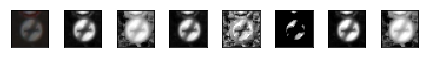

In [17]:




plot_image(X_train[0],1,8,1,"")
plot_image(X_train_g[0].squeeze(),1,8,2,"")
plot_image(X_train_h[0].squeeze(),1,8,3,"")
plot_image(X_train_n[0].squeeze(),1,8,4,"")
plot_image(X_train_hae[0].squeeze(),1,8,5,"")
plot_image(X_train_ae[0].squeeze(),1,8,6,"")
plot_image(X_train_cs[0].squeeze(),1,8,7,"")
plot_image(X_train_hcs[0].squeeze(),1,8,8,"")


In [ ]:
plot_images(-1,X_test_h[:20],5,"" )

# SPATIAL TRANSFORMER 

In [18]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
        A value of 1 will keep the orignal size of the image.
        Values larger than 1 will down sample the image. Values below 1 will
        upsample the image.
        example image: height= 100, width = 200
        downsample_factor = 2
        output image will then be 50, 100
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.regularizers = self.locnet.regularizers //NOT SUER ABOUT THIS, THERE IS NO MORE SUCH PARAMETR AT self.locnet
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, [-1])
        y_coordinates = tf.reshape(y_coordinates, [-1])
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?

        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, (batch_size, 3, -1))

        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image


# LOCNET

In [19]:
def locnet():

    # initial weights
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]

    input_shape = (32,32,1)

    #locnet
    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
    locnet.add(Conv2D(20, (5, 5)))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Conv2D(20, (5, 5)))

    locnet.add(Flatten())
    locnet.add(Dense(50))
    locnet.add(LeakyReLU(alpha=0.5))
    locnet.add(Dense(6, weights=weights))
    return locnet
    #locnet.add(Activation('sigmoid'))

#  CNN model 

In [20]:
def cnn_model(flag_BN=False, flag_STN=False):

    
    model = Sequential()
    if flag_STN == True:
        lnet = locnet()
        print(lnet)
        model.add(SpatialTransformer(localization_net=lnet,
                            input_shape=(32,32,1),output_size=(32,32)))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=( 32, 32,1)))                    
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.summary()
    return model

In [21]:
def deep_locnet(input_shape=(32,32,1)):

 
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((64, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(16, (1,1), padding='valid', input_shape=input_shape))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3,3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(128, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(1, 1)))
   


    locnet.add(Flatten())
    locnet.add(Dense(128))
    locnet.add(Activation('elu'))
    locnet.add(Dense(64))
    locnet.add(Activation('elu'))
    locnet.add(Dense(6, weights=weights))
    locnet.summary()
    return locnet
l = deep_locnet()
print(l)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [22]:
def deep_cnn_model(flag_BN=True, flag_STN=True):

    
    model = Sequential()
 
    if flag_STN == True:
        lnet = deep_locnet()
        print(lnet)
        model.add(SpatialTransformer(localization_net=lnet, input_shape=(32,32,1),
                           output_size=(32,32)))
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=( 32, 32,1)))                    
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

  
    model.add(Conv2D(64, (3, 3), padding='same'))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    #model.summary()
    return model

# CNN  with Batch Normalization

In [124]:
l = deep_cnn_model(flag_BN=True,flag_STN=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 3200)              0         
__________

In [125]:


#y_aug = np_utils.to_categorical(y_aug,num_classes=43)

In [126]:
#def print_shape(X_tr,y_tr,X_te,y_te,X_va,y_va)
print(X_train_g.shape)
print(y_train_e.shape)
print(X_test_g.shape)
print(y_test_e.shape)
print(X_val_g.shape)
print(y_val_e.shape)



(34799, 32, 32, 1)
(34799, 43)
(12630, 32, 32, 1)
(12630, 43)
(4410, 32, 32, 1)
(4410, 43)


In [55]:


from keras.callbacks import LearningRateScheduler, ModelCheckpoint,ReduceLROnPlateau



    if flag_aug == True:
        label = "_"+str(i)+"_aug_"
    else:
        label = "_"+str(i)+"_"
    if flag_BN==False:
        label = label+"nobn_"
        
    batch_size = 512
    epochs = 15
    #model_g = cnn_model(flag_BN=True)
    lr=0.01
    adam = Adam(lr=lr)
    #def lr_schedule(epochs):
    #    return lr * (0.01 ** int(epochs / 10))
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
     
    checkpointer = ModelCheckpoint(filepath="weights_"+label+".hdf5", verbose=1, save_best_only=True, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=3, min_lr=0.0001)
    try:
        print("Train model")

        history =  model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_v, y_v),
                    shuffle=True,
                    callbacks=[checkpointer])
                    #callbacks=[checkpointer,LearningRateScheduler(lr_schedule)])
                    #callbacks=[checkpointer,reduce_lr])

    except KeyboardInterrupt:
        print("training interrupted")

    
    #model.load_weights("weights_"+label+".hdf5")
    evaluate = model.evaluate(X_te,y_te)
    print("---------------------------------------")
    print(evaluate)
    
    return history, model, evaluate


In [142]:

#model = cnn_model(flag_BN=True,flag_STN=True)

model = deep_cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="weights_"+str(0)+".hdf5", verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(X_train_hae, y_train_e,
                    batch_size=512, nb_epoch=10,
                    callbacks=[checkpointer],
                    verbose=1, validation_data=(X_val_hae, y_val_e))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 3200)              0         
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 29s - loss: 1.8041 - acc: 0.5182 - val_loss: 4.4615 - val_acc: 0.0190
Epoch 2/10
34799/34799 [==============================] - 23s - loss: 0.3330 - acc: 0.9008 - val_loss: 5.4322 - val_acc: 0.0204
Epoch 3/10
34799/34799 [==============================] - 23s - loss: 0.1518 - acc: 0.9566 - val_loss: 5.5519 - val_acc: 0.0204
Epoch 4/10
34799/34799 [==============================] - 23s - loss: 0.0934 - acc: 0.9742 - val_loss: 5.1658 - val_acc: 0.0302
Epoch 5/10
34799/34799 [==============================] - 23s - loss: 0.0621 - acc: 0.9827 - val_loss: 3.5641 - val_acc: 0.1866
Epoch 6/10
34799/34799 [==============================] - 23s - loss: 0.0498 - acc: 0.9863 - val_loss: 1.9647 - val_acc: 0.3937
Epoch 7/10
34799/34799 [==============================] - 23s - loss: 0.0367 - acc: 0.9905 - val_loss: 0.5640 - val_acc: 0.8215
Epoch 8/10
34799/34799 [==============================]

In [145]:
e=model.evaluate(X_test_hae,y_test_e)
print(e)

12576/12630 [============================>.] - ETA: 0s[0.1178240984808049, 0.96524148859490688]


In [151]:

#model = cnn_model(flag_BN=True,flag_STN=True)

model = cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="weights_cnn_all_aug_onHAE.hdf5", verbose=1, save_best_only=True, save_weights_only=True)
try:
    history = model.fit(X_aug_all, y_aug_all_e,
                    batch_size=512, nb_epoch=10,
                    callbacks=[checkpointer],
                    verbose=1, validation_data=(X_val_hae, y_val_e))
except KeyboardInterrupt:
        print("training interrupted")
        
print(model.evaluate(X_test_hae,y_test_e))
print(model.evaluate(np.asarray(X_test_hcs),y_test_e))
print(model.evaluate(X_test_h,y_test_e))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_26 (Spat (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_160 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 16, 16, 64)        18496     
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 117297 samples, validate on 4410 samples
Epoch 1/10
117297/117297 [==============================] - 64s - loss: 0.8799 - acc: 0.7585 - val_loss: 1.1685 - val_acc: 0.7091
Epoch 2/10
117297/117297 [==============================] - 58s - loss: 0.2378 - acc: 0.9322 - val_loss: 0.1643 - val_acc: 0.9571
Epoch 3/10
117297/117297 [==============================] - 58s - loss: 0.1499 - acc: 0.9575 - val_loss: 0.0453 - val_acc: 0.9884
Epoch 4/10
117297/117297 [==============================] - 58s - loss: 0.1126 - acc: 0.9681 - val_loss: 0.0390 - val_acc: 0.9875
Epoch 5/10
117297/117297 [==============================] - 58s - loss: 0.0893 - acc: 0.9746 - val_loss: 0.0306 - val_acc: 0.9902
Epoch 6/10
117297/117297 [==============================] - 58s - loss: 0.0745 - acc: 0.9790 - val_loss: 0.0219 - val_acc: 0.9916
Epoch 7/10
117297/117297 [==============================] - 58s - loss: 0.0666 - acc: 0.9806 - val_loss: 0.0234 - val_acc: 0.9934
Epoch 8/10
117297/117297 [==============

In [ ]:
model.save("cnn_model_all_aug_97.h5")



In [172]:

a = model.predict(X_test_hae,batch_size=1)

KeyboardInterrupt: 

conv_layers
3
<class 'numpy.ndarray'>
Top 3 Predicitons:
	11: 1.0
	30: 8.86395e-10
	27: 2.94324e-12

Actual: 11


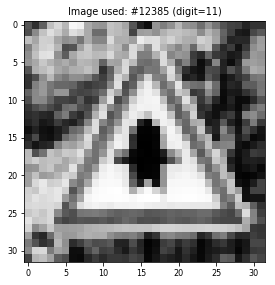

Visualizing Convolutions Layer 0


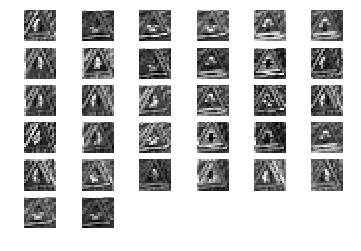

Visualizing Convolutions Layer 1


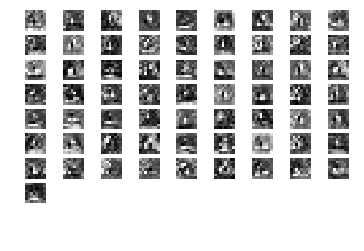

Visualizing Convolutions Layer 2


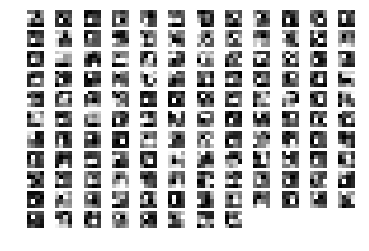

Top 3 Predicitons:
	12: 0.999988
	17: 5.23141e-06
	16: 2.51519e-06

Actual: 12


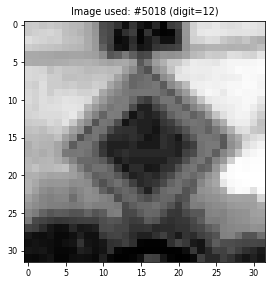

Visualizing Convolutions Layer 0


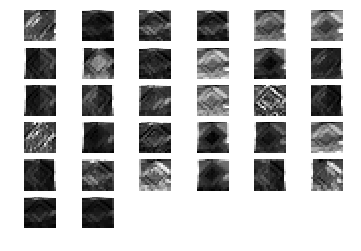

Visualizing Convolutions Layer 1


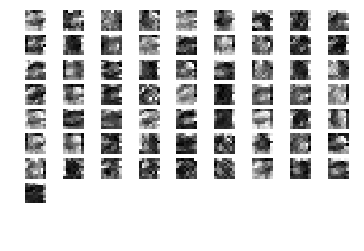

Visualizing Convolutions Layer 2


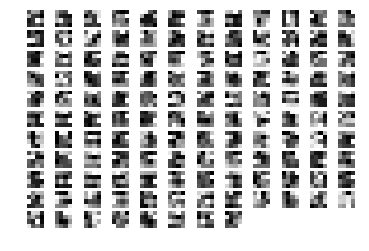

Top 3 Predicitons:
	3: 0.999181
	5: 0.000804155
	2: 1.44207e-05

Actual: 3


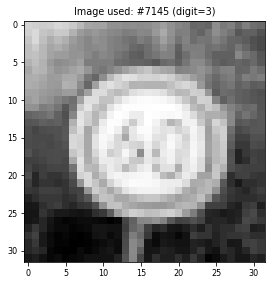

Visualizing Convolutions Layer 0


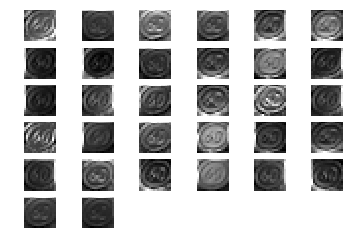

Visualizing Convolutions Layer 1


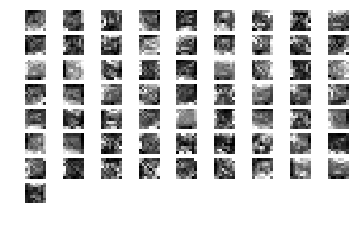

Visualizing Convolutions Layer 2


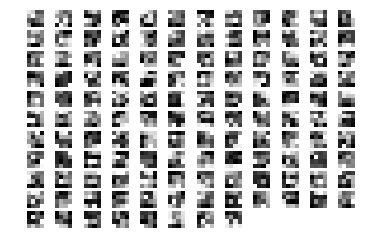

In [175]:
from math import sqrt

import matplotlib.pyplot as plt
from keras import backend as K

n_imgs = 3
#model_fn = 'cnn_moddel....h5'

# Function by gcalmettes from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1, titles=False):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(sorted(figures.keys(), key=lambda s: int(s[3:]))):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        if titles:
            axeslist.ravel()[ind].set_title(title)

    for ind in range(nrows*ncols):
        axeslist.ravel()[ind].set_axis_off()

    if titles:
        plt.tight_layout()
    plt.show()


def get_dim(num):
    """
    Simple function to get the dimensions of a square-ish shape for plotting
    num images
    """

    s = sqrt(num)
    if round(s) < s:
        return (int(s), int(s)+1)
    else:
        return (int(s)+1, int(s)+1)

# Load the best model
#model = load_model(model_fn)

# Get the convolutional layers
conv_layers = [layer for layer in model.layers if isinstance(layer, MaxPooling2D)]
print("conv_layers")
# Pick random images to visualize
print(n_imgs)
imgs_to_visualize = np.random.choice(np.arange(0, len(X_test_h)), n_imgs)
print(type(imgs_to_visualize))
#print(imgs_to_visualize)

# Use a keras function to extract the conv layer data
convout_func = K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
conv_imgs_filts = convout_func([X_test_h[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted

#vis_imgs = []
#for i in imgs_to_visualize:
#    vis_imgs.append(X_test_hae[i])
#a = X_test_hae[imgs_to_visualize]
#print(np.asarray(vis_imgs).shape)
#print(a.shape)

x_sel = X_test_h[imgs_to_visualize]
y_sel = y_test[imgs_to_visualize]


predictions = model.predict(X_test_h[imgs_to_visualize],batch_size=1)
#print(predictions)
imshow = plt.imshow #alias
# Loop through each image disply relevant info
for img_count, img_to_visualize in enumerate(imgs_to_visualize):

    # Get top 3 predictions 
    top3_ind = predictions[img_count].argsort()[-3:]
    #top3_species = np.array(LABELS)[top3_ind]
    top3_preds = predictions[img_count][top3_ind]

    # Get the actual leaf species
    actual = y_test[img_to_visualize]

    # Display the top 3 predictions and the actual species
    print("Top 3 Predicitons:")
    for i in range(2, -1, -1):
        print("\t%s: %s" % (top3_ind[i], top3_preds[i]))
    print("\nActual: %s" % actual)

    # Show the original image
    plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, y_test[img_to_visualize]))
    # For Theano users comment the line below and
    imshow(X_test_h[img_to_visualize][:, :, 0], cmap='gray')
    # imshow(X_img_val[img_to_visualize][0], cmap='gray') # uncomment this
    plt.tight_layout()
    plt.show()

    # Plot the filter images
    for i, conv_imgs_filt in enumerate(conv_imgs_filts):
        conv_img_filt = conv_imgs_filt[img_count]
        print("Visualizing Convolutions Layer %d" % i)
        # Get it ready for the plot_figures function
        # For Theano users comment the line below and
        fig_dict = {'flt{0}'.format(i): conv_img_filt[:, :, i] for i in range(conv_img_filt.shape[-1])}
        # fig_dict = {'flt{0}'.format(i): conv_img_filt[i] for i in range(conv_img_filt.shape[-1])} # uncomment this
        plot_figures(fig_dict, *get_dim(len(fig_dict)))

In [104]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint,ReduceLROnPlateau

#model = cnn_model(flag_BN=True,flag_STN=True)
adam = Adam(lr = 0.0.01)



model = deep_cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="weights_"+str(8)+".hdf5", verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(X_aug_all, y_aug_all_e,
                    batch_size=200, nb_epoch=100,
                    callbacks=[checkpointer],
                    verbose=1, validation_data=(X_val_hae, y_val_e))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3200)              0         
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 117297 samples, validate on 4410 samples
Epoch 1/100
117297/117297 [==============================] - 89s - loss: 0.7817 - acc: 0.7875 - val_loss: 0.0686 - val_acc: 0.9848
Epoch 2/100
117297/117297 [==============================] - 86s - loss: 0.1505 - acc: 0.9571 - val_loss: 0.0305 - val_acc: 0.9916
Epoch 3/100
117297/117297 [==============================] - 86s - loss: 0.1007 - acc: 0.9717 - val_loss: 0.0244 - val_acc: 0.9909
Epoch 4/100
117297/117297 [==============================] - 86s - loss: 0.0742 - acc: 0.9786 - val_loss: 0.0275 - val_acc: 0.9907
Epoch 5/100
117297/117297 [==============================] - 86s - loss: 0.1023 - acc: 0.9719 - val_loss: 0.0576 - val_acc: 0.9823
Epoch 6/100
117297/117297 [==============================] - 86s - loss: 0.0879 - acc: 0.9744 - val_loss: 0.0205 - val_acc: 0.9943
Epoch 7/100
117297/117297 [==============================] - 86s - loss: 0.0552 - acc: 0.9837 - val_loss: 0.0261 - val_acc: 0.9934
Epoch 8/100
117297/117297 [======

KeyboardInterrupt: 

In [107]:
print(history.history)

NameError: name 'history' is not defined

In [105]:
ev = model.evaluate(X_test_h, y_test_e)
print(ev)
ev = model.evaluate(X_test_hae, y_test_e)
print(ev)
ev = model.evaluate(np.asarray(X_test_hcs), y_test_e)
print(ev)
model.save("8_deep_cnn_89_all_aug_on_hae.h5")


12576/12630 [============================>.] - ETA: 0s[0.080242745913734301, 0.97917656381264251]


In [128]:
n=[X_train_n,y_train_e,X_val_n,y_val_e,X_test_n,y_test_e]
h=[X_train_h,y_train_e,X_val_h,y_val_e,X_test_h,y_test_e]
hae=[X_train_hae,y_train_e,X_val_hae,y_val_e,X_test_hae,y_test_e]
ae = [X_train_ae,y_train_e,X_val_ae,y_val_e,X_test_ae,y_test_e]
cs = [np.asarray(X_train_cs),y_train_e,np.asarray(X_val_cs),y_val_e,np.asarray(X_test_cs),y_test_e]
hcs = [np.asarray(X_train_hcs),y_train_e,np.asarray(X_val_hcs),y_val_e,np.asarray(X_test_hcs),y_test_e]





hae_a=[X_aug_hae,y_aug_hae_e,X_val_hae,y_val_e,X_test_hae,y_test_e]
hcs_a = [np.asarray(X_aug_hcs),y_aug_hae_e,np.asarray(X_val_hcs),y_val_e,np.asarray(X_test_hcs),y_test_e]
n_a=[X_aug_n,y_aug_n_e,X_val_n,y_val_e,X_test_n,y_test_e]
h_a=[X_aug_h,y_aug_h_e,X_val_h,y_val_e,X_test_h,y_test_e]
hae_a=[X_aug_hae,y_aug_hae_e,X_val_hae,y_val_e,X_test_hae,y_test_e]
ae_a = [X_aug_ae,y_aug_ae_e,X_val_ae,y_val_e,X_test_ae,y_test_e]
cs_a = [np.asarray(X_aug_cs),y_aug_cs_e,np.asarray(X_val_cs),y_val_e,np.asarray(X_test_cs),y_test_e]
hcs_a = [np.asarray(X_aug_hcs),y_aug_hcs_e,np.asarray(X_val_hcs),y_val_e,np.asarray(X_test_hcs),y_test_e]
all_h = [X_all, y_all_e,X_val_h,y_val_e,X_test_h,y_test_e]
all_aug_h = [X_aug_all, y_aug_all_e,X_val_h,y_val_e,X_test_h,y_test_e]


#x_all_aug = np.append(x_all_aug, axis=0)

In [190]:
#predict = model.predict(X_test_hae, batch_size=1)
#print(predict)
#proba = model.predict_proba(X_test_hae, batch_size=1)
#print(proba)
classes = model.predict_classes(X_test_h, batch_size=1)
print(classes)
print(y_test)


print('class value', 'original' 'predicted')
j=0
indices=[]
for i in range(len(y_test)):
    
    if (y_test[i]!=classes[i]):
        #print(str(i)+"   " +str(classes[i])+"     "    +str(y_test[i]))
        indices.append(i)
        j+=1
    
print(len(indices))

    
#e = model.evaluate(X_test_hae,y_test_e)
#print(e)
#s = dr[0][1]
#e = model.evaluate(X_test_h,y_test_e)
#print(e)
#print(np.asarray(X_test_cs).shape)

12625/12630 [============================>.] - ETA: 0s[16  1 38 ...,  5  7 10]
[16  1 38 ...,  6  7 10]
class value originalpredicted
272


In [197]:
mismatch = []
for i in range(len(indices)):
    mismatch.append(X_test_g[indices[i]])
    
    

There are 20 images in the  dataset


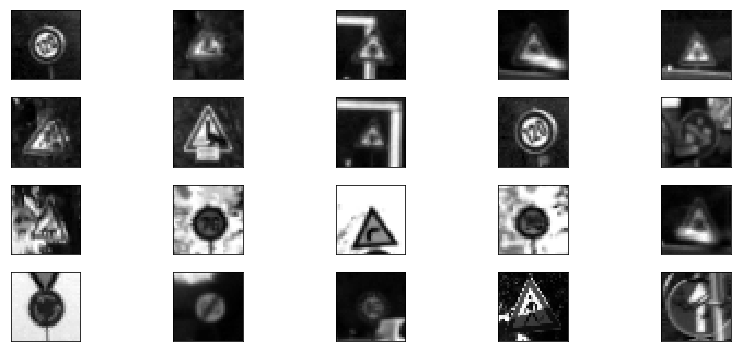

In [198]:
plot_images(-1, mismatch[:20],5,"")

There are 20 images in the  dataset


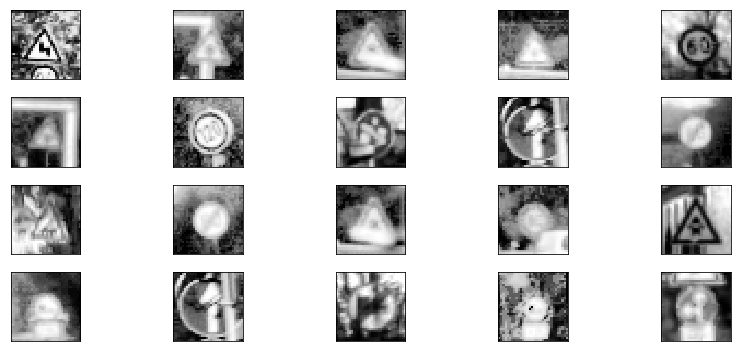

In [189]:
plot_images(-1, mismatch[:20],5,"")

There are 20 images in the  dataset


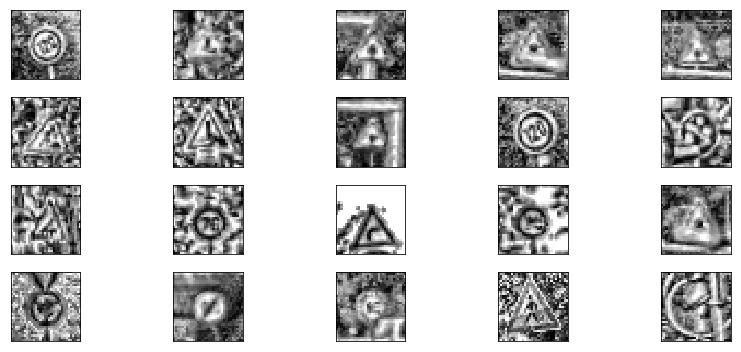

In [196]:
plot_images(-1, mismatch[:20],5,"")

In [23]:
#print class errors
def print_class_errors(class_errors, y):
    y_bins = np.bincount(y)
    errors_percent = []
    for errors,i in zip(class_errors, range(len(class_errors))):
        errors_percent.append(100*errors/y_bins[i])
        print("class {}: errors={} of {} samples ({:.1f}%) ".format(i, errors, y_bins[i], errors_percent[i]))
    return errors_percent

errors_percent = print_class_errors(results.class_errors, yN_valid)
print("median error={:.2f}%  avg error={:.2f}%".format(statistics.median(errors_percent), statistics.mean(errors_percent)))

plt.plot(range(len(errors_percent)), errors_percent)
plt.title('Error distribution per class')
plt.xlabel('class')
plt.ylabel('% errors')
plt.show()

NameError: name 'results' is not defined

In [ ]:
#load model
#load weights
#evaluate on data hae
#predict_classes
#

In [24]:
from keras.models import load_model



#model_deep= load_model('deep_cnn_89_all_aug_on_hae.h5',custom_objects={'STN':SpatialTransformer})

model_deep = deep_cnn_model(flag_BN=True,flag_STN=True)
model_cnn = cnn_model(flag_BN=True,flag_STN=True)

#model_deep.load_weights("weights_deep_cnn_98.hdf5")
model_deep.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


model_deep.load_weights('weights_deep_cnn_98.hdf5')
model_cnn.load_weights('weights_cnn_all_aug_onHAE.hdf5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

In [27]:
deep_e= model_deep.evaluate(X_test_hae,y_test_e)
cnn_e = model_cnn.evaluate(X_test_hae,y_test_e)

12512/12630 [============================>.] - ETA: 0s

In [28]:
print(deep_e)
print(cnn_e)

[0.070157761389262621, 0.98115597790607079]
[0.11396379067007935, 0.97070467146445338]


<class 'numpy.ndarray'>
43
[(1, 3), (2, 6), (3, 12), (4, 4), (5, 12), (6, 4), (8, 24), (10, 11), (11, 22), (12, 13), (13, 2), (15, 22), (17, 2), (18, 28), (21, 1), (22, 14), (25, 5), (30, 16), (31, 4), (35, 13), (36, 1), (38, 8), (39, 1), (42, 10), [39, 8, 15], [48, 18, 24], [50, 25, 31], [127, 30, 25], [237, 30, 38], [247, 8, 9], [270, 18, 26], [309, 38, 26], [314, 1, 4], [325, 35, 37], [339, 22, 20], [430, 11, 23], [496, 30, 27], [527, 5, 3], [727, 11, 23], [734, 15, 4], [776, 15, 33], [882, 10, 31], [894, 35, 15], [1209, 11, 23], [1275, 8, 15], [1364, 8, 15], [1402, 30, 19], [1462, 42, 41], [1489, 12, 15], [1490, 12, 13], [1512, 18, 26], [1560, 42, 13], [1573, 3, 5], [1674, 15, 7], [1726, 10, 9], [1741, 36, 39], [1753, 18, 26], [1781, 38, 36], [1836, 15, 33], [1857, 12, 40], [1994, 11, 27], [2002, 8, 7], [2109, 30, 28], [2112, 18, 26], [2124, 11, 23], [2191, 5, 2], [2235, 8, 9], [2332, 42, 36], [2342, 18, 21], [2379, 12, 16], [2428, 5, 2], [2457, 2, 3], [2460, 11, 23], [2494, 2, 1],

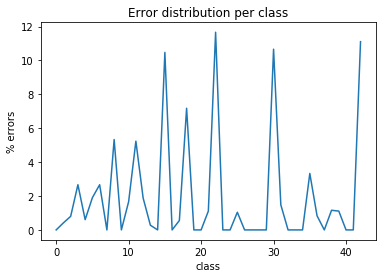

In [102]:
 #predict = model.predict(X_test_hae, batch_size=1)
#print(predict)
#proba = model.predict_proba(X_test_hae, batch_size=1)
#print(proba)

#predictions = model_deep.predict_classes(X_test_hae, batch_size=1)






def get_errors_per_class(predictions):

    # index in test, original truth, mismatched truth
    
    mismatched = []
    indices = []
      
    error_classes
    for i in range(len(y_test)):
        
        if (y_test[i]!=predictions[i]):
               mismatched.append(y_test[i]) 
               
               error_classes.append([i,y_test[i],predictions[i]])
    miss_hist = np.bincount(mismatched)  
    
    #print(type(miss_hist))      
    #print(len(miss_hist))
    sum = 0
    for i  in range(len(miss_hist)):
        if (miss_hist[i]!=0):
            sum=sum+miss_hist[i]
            
    return miss_hist, error_classes, sum,mismatched,indices

miss_hist,error_classes, sum ,mismatched,indices= get_errors_per_class(predictions)
print(error_classes)
#print(miss_hist)
#print(error_classes)
                                 
#print(sum)
                                 
def graph_class_errors(class_errors, y):
    y_bins = np.bincount(y)
    errors_percent = []
    for errors,i in zip(class_errors, range(len(class_errors))):
        errors_percent.append(100*errors/y_bins[i])
        print("class {}: errors={} of {} samples ({:.1f}%) ".format(i, errors, y_bins[i], errors_percent[i]))
    return errors_percent

errors_percent = print_class_errors(miss_hist, y_test)
print("median error={:.2f}%  avg error={:.2f}%".format(statistics.median(errors_percent), statistics.mean(errors_percent)))

plt.plot(range(len(errors_percent)), errors_percent)
plt.title('Error distribution per class')
plt.xlabel('class')
plt.ylabel('% errors')
plt.show()
    


In [62]:
predictions_cnn = model_cnn.predict_classes(X_test_hae, batch_size=1)
miss_hist_cnn,error_classes_cnn, sum_cnn,mismatched_cnn = get_errors_per_class(predictions_cnn)
print(miss_hist_cnn)
print(error_classes_cnn)

errors_percent = print_class_errors(miss_hist_cnn, y_test)
print("median error={:.2f}%  avg error={:.2f}%".format(statistics.median(errors_percent), statistics.mean(errors_percent)))

plt.plot(range(len(errors_percent)), [errors_percent,errors_percent_cnn])
plt.title('Error distribution per class')
plt.xlabel('class')
plt.ylabel('% errors')
plt.show()

12623/12630 [============================>.] - ETA: 0s<class 'numpy.ndarray'>
43
[ 1  9  6 33  6 12  1 13 11  1 35 22  2  1  0  6  0 14 41  0  1  1 10  4  3
 16  0 11  0  0 40  6 19  1  0  1  0  0 21  4  6  1 11]
[(0, 1), (1, 9), (2, 6), (3, 33), (4, 6), (5, 12), (6, 1), (7, 13), (8, 11), (9, 1), (10, 35), (11, 22), (12, 2), (13, 1), (15, 6), (17, 14), (18, 41), (20, 1), (21, 1), (22, 10), (23, 4), (24, 3), (25, 16), (27, 11), (30, 40), (31, 6), (32, 19), (33, 1), (35, 1), (38, 21), (39, 4), (40, 6), (41, 1), (42, 11)]
class 0: errors=1 of 60 samples (1.7%) 
class 1: errors=9 of 720 samples (1.2%) 
class 2: errors=6 of 750 samples (0.8%) 
class 3: errors=33 of 450 samples (7.3%) 
class 4: errors=6 of 660 samples (0.9%) 
class 5: errors=12 of 630 samples (1.9%) 
class 6: errors=1 of 150 samples (0.7%) 
class 7: errors=13 of 450 samples (2.9%) 
class 8: errors=11 of 450 samples (2.4%) 
class 9: errors=1 of 480 samples (0.2%) 
class 10: errors=35 of 660 samples (5.3%) 
class 11: errors=22

NameError: name 'errors_percent_cnn' is not defined

In [60]:
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline

def compare_distribution_histograms(data, descs):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
    ret_data_bins = []    
    for dataset, desc in zip(data, descs):
        # Create a histogram of the classes
        #data_bins = np.bincount(dataset)
        # Convert to percent
        #data_bins = data_bins / len(dataset) * 100
        data_bins = dataset
        print(data_bins)
        ret_data_bins.append(data_bins)

        print("Dataset {} contains {} samples".format(desc, len(dataset)))
        print("median={:.2f}%  mean={:.2f}%".format(statistics.median(data_bins), statistics.mean(data_bins)))

        
        ax0.plot(range(len(dataset)), dataset,label=desc)
        ax0.set_title('Error distribution per class')
        ax0.set_xlabel('class')
        ax0.set_ylabel('no of errors')
        
        ax1.hist(dataset, 10, label=desc)
        ax1.set_title('Error Distribution, histogram')
        ax1.set_xlabel('classes')
        ax1.set_ylabel('# errors')
    ax0.legend(loc=1)
    ax1.legend(loc=1)
    plt.show()
    return ret_data_bins

[ 0  3  6 12  4 12  4  0 24  0 11 22 13  2  0 22  0  2 28  0  0  1 14  0  0
  5  0  0  0  0 16  4  0  0  0 13  1  0  8  1  0  0 10]
Dataset deep contains 43 samples
median=1.00%  mean=5.00%
[ 1  9  6 33  6 12  1 13 11  1 35 22  2  1  0  6  0 14 41  0  1  1 10  4  3
 16  0 11  0  0 40  6 19  1  0  1  0  0 21  4  6  1 11]
Dataset cnn contains 43 samples
median=4.00%  mean=8.00%


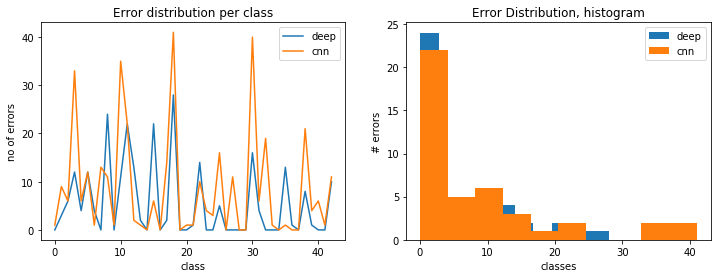

In [61]:

# Let's check if there's similar representation of image classes in the Training and Validation datasets
hist = compare_distribution_histograms(data=[miss_hist,miss_hist_cnn], descs=["deep","cnn"])


In [ ]:
#Confusion  matrix

proba = model_deep.predict_proba(X_test_hae, batch_size=1)
#print(proba)

In [96]:
#proba_a = model_deep.predict(X_test_hae, batch_size=1)
#error_probs = proba[mismatched]
#for i in range(len(mismatched)):
#    print('%d %d' % (mismatched[i], error_probs[mismatched[i]][predictions[i]]))
    
i = mismatched[0]



print('%d %d %d' % (i,predictions[i],y_test[i]))

1 1 1


In [ ]:
import keras.backend as K
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

In [ ]:
batch_size = 512
print(X_train.shape[0]/batch_size)


In [ ]:
import matplotlib.pyplot as plt
from keras.utils import np_utils, generic_utils

nb_epochs = 5 # you probably want to go longer than this
batch_size = 512
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(10):
            print(b)
            f = b * batch_size
            #print(f)
            l = (b+1) * batch_size
            #print(l)
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            progbar.add(X_batch.shape[0], values=[("train loss", loss[0])])
            #progbar.add(args.batch_size, values=[("train loss", loss[0])])

        scorev = model.evaluate(X_val, y_val, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            print(e)
            Xresult = F([X_batch[:9]])
            #print(Xresult)
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

In [ ]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

In [ ]:
model.save('models/STN_BN_CNN.ckpt')
model.evaluate(X_test,y_test)

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')